In [111]:
!pip install pandas-datareader==0.10.0
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Only the 'DCOILWTICO' has a daily sampling frequency, so we'll use this one. The price is given in dollars per barrel, and the time series extends all the way back from 1986 (January the second) to today (January 9th, 2023 at the time of writing).

In [113]:
start = dt.datetime(1986, 1, 1)
end = dt.datetime(2023, 5, 22)
wti_oil_price = web.DataReader('DCOILWTICO', 'fred', start, end)

wti_oil_price

,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-05-16,70.85
2023-05-17,72.78
2023-05-18,71.82


In [114]:
data = pd.DataFrame(wti_oil_price)

In [115]:
data.rename(columns = {'DCOILWTICO':'Price'}, inplace = True)

In [116]:
data

,Price
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-05-16,70.85
2023-05-17,72.78
2023-05-18,71.82


In [117]:
data.to_csv("OIl dataset.csv")

##import the dataset

In [118]:
Oil = pd.read_csv("OIl dataset.csv")

In [119]:
Oil.head()

,DATE,Price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [120]:
Oil = Oil.set_index(['DATE'])
Oil.tail()

,Price
DATE,
2023-05-16,70.85
2023-05-17,72.78
2023-05-18,71.82
2023-05-19,71.57
2023-05-22,71.81


In [121]:
Oil.isnull().sum()

Price    333
dtype: int64

In [122]:
oil_filled1 = Oil.fillna(method='ffill')

In [123]:
oil_filled1.isnull().sum()

Price    0
dtype: int64

In [124]:
oil_filled1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9753 entries, 1986-01-02 to 2023-05-22
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9753 non-null   float64
dtypes: float64(1)
memory usage: 152.4+ KB


In [125]:
oil_filled1.describe()

,Price
count,9753.000000
mean,46.384429
std,29.583331
min,-36.980000
25%,20.040000
50%,36.910000
75%,68.290000
max,145.310000


In [126]:
oil_filled1.duplicated().sum()

4472

In [127]:
oil_filled1

,Price
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-05-16,70.85
2023-05-17,72.78
2023-05-18,71.82


<Axes: xlabel='DATE'>

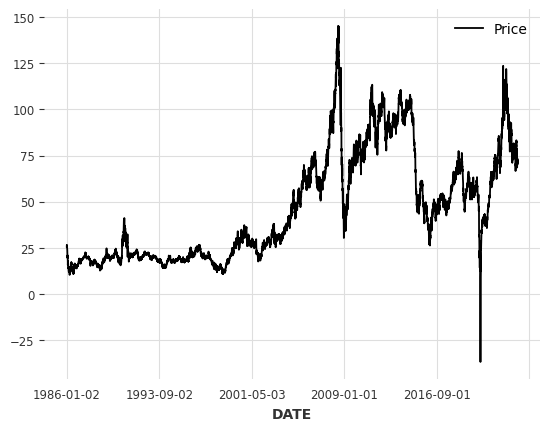

In [128]:
oil_filled1.plot()

####**Subprimes crisis of 2008**

Another huge spike appears around july 2008, although it is preceded by a longer phase of growth starting around 2002 which can be explained by the prosperous general economic conditions. The maximum happens on the 7th of July 2008 with a value of **$ 145.31**, followed by a steep decline, reaching a minimum on the 23rd of december 2008 at barely 30.28 dollars.

####**Covid-19**

We all remember the covid-19 pandemic, and so does the WTI crude oil dataset. Here for the first time, we even see a negative (!) price in it. The price per barrel dropped all the way down to **-36.98 **on the 4th of April 2020, following various lockdown decisions, which heavily reduced travel and thus ultimately the need for oil. Because the oil consumption sank so drastically, there started to be a shortage of storage for physical oil, so that futures contracts got massively shorted in order for their holders not to have to take delivery of the physical goods.

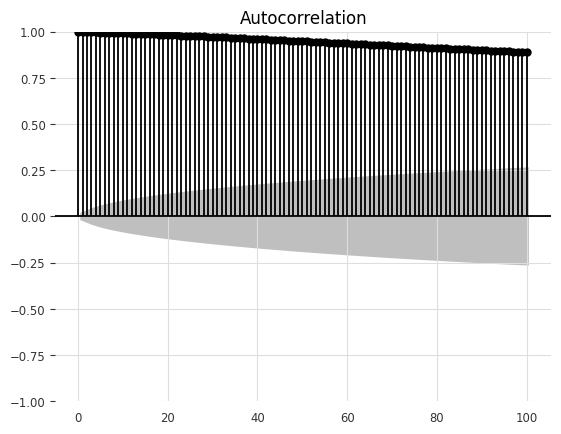

In [129]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot = plot_acf(oil_filled1['Price'], lags=100)

The autocorrelation decays roughly linelarly to zero, a behaviour expected for an AR time series with trend. The light blue bell shape around the x-axis is the 95% confidence interval, meaning anything that is above it is statistically significant. In this case, the autocorrelation's value is very much above that threshold.

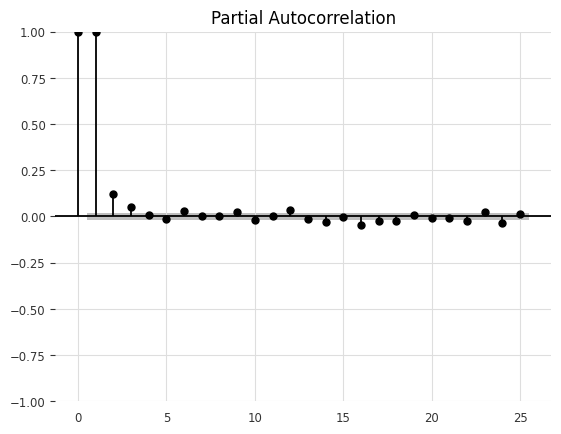

In [130]:

plot = plot_pacf(oil_filled1['Price'], method='ywm',lags=25)

Conclusions from the ACF and PACF plots
The plots for the autocorrelation function and partial autocorrelation function are typical of an autoregressive (AR in what follows) series, 
 As is obvious from their definition and the autocorrelation plot from above, those have strong time dependencies and we should take care of that before moving on. It is often the case for such time series, that differencing them once (differencing is the equivalent of differentiating but for functions defined on a discrete interval) takes care of the autocorrelation. That means that the differenced stock should not display a strong autocorrelation anymore. Let's see if that's true:

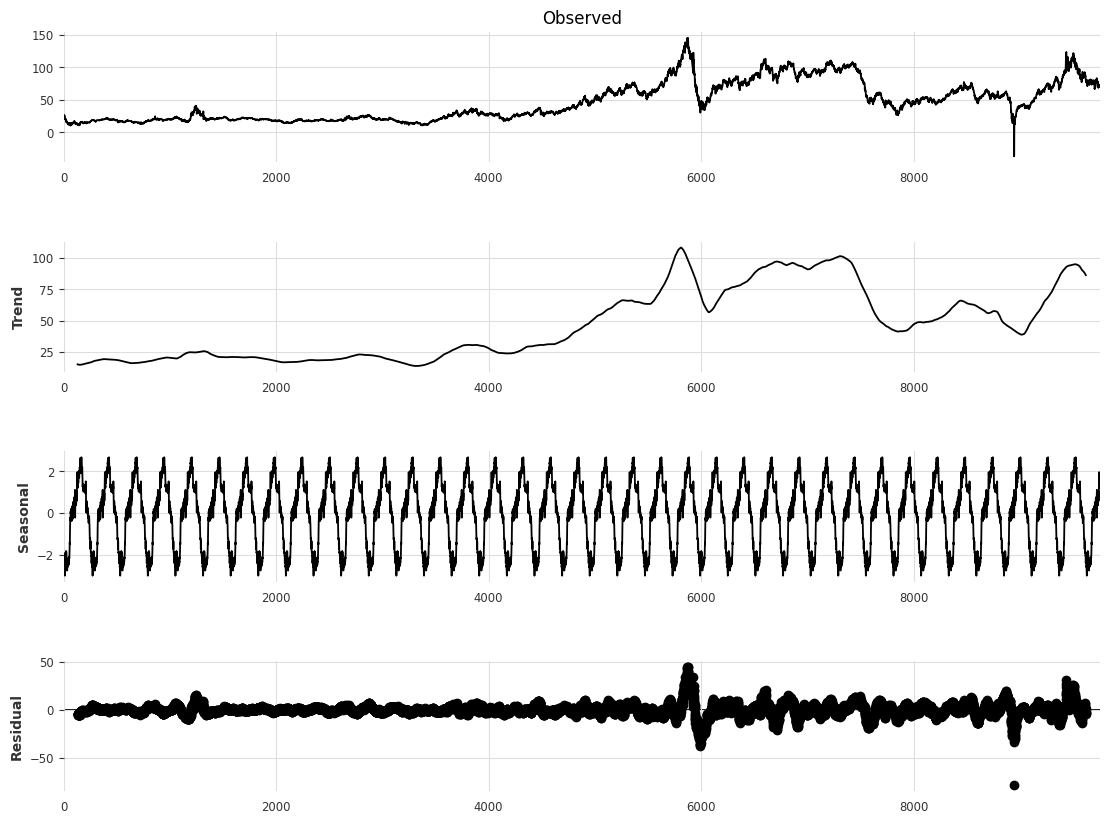

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(oil_filled1['Price'].values, period=260, model='additive')
figure = decomposition.plot()
figure.set_size_inches((12, 9))

The periodictiy of  260
  represents the average number of business days in a year. While the seasonal_decompose method provided by the statsmodels package is naive (for instance the trend part is a simple moving average), it nonetheless gives an idea of the importance of certain components. We see notably that the seaonal has a small amplitude of about  2
  and can therefore be neglected. The trend is not completely negligible, so let's test more formally with the to see if the stationarity hypothesis can be discarded or not. We'll use the augmented Dickey-Fuller test for that, which is also provided by the statsmodels package:

In [132]:
## Temporary DataFrame
temp_data = oil_filled1.copy()
temp_data['DATE'] = temp_data.index
temp_data['DATE']  = pd.to_datetime(temp_data['DATE'])
temp_data['DATE'] = temp_data['DATE'].dt.strftime('%Y')

Text(0.5, 1.0, 'Box Plot Year Wise-WTI')

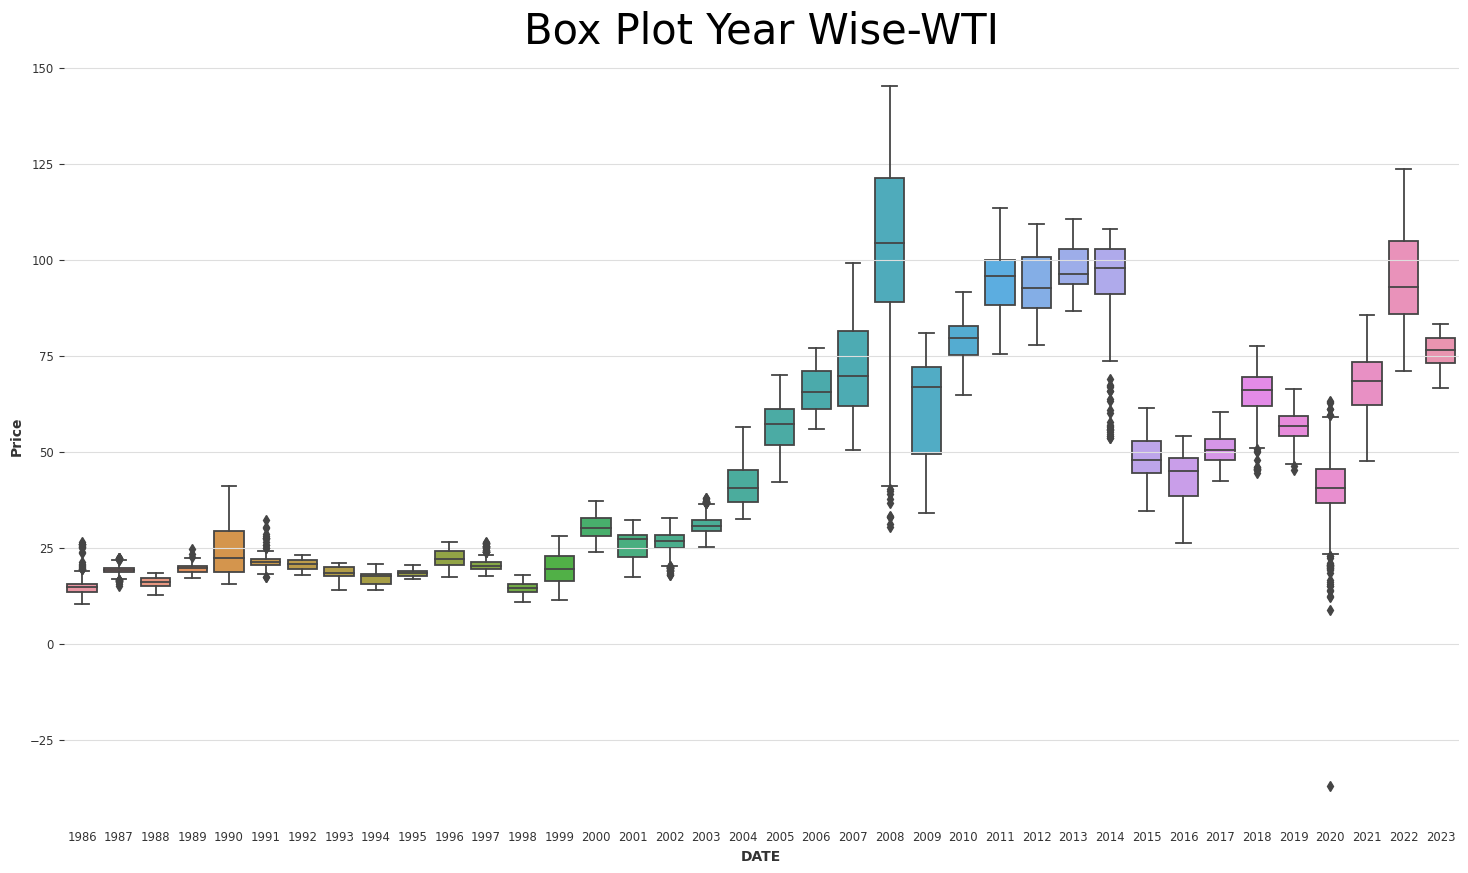

In [133]:
##Box Plot Year Wise WTI
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=temp_data['DATE'], y=temp_data['Price'])
ax.set_title('Box Plot Year Wise-WTI',fontsize=30)

In [134]:
oil_1986_2023 = temp_data['Price']

In [135]:
oil_1986_2023 = pd.DataFrame(oil_1986_2023)
oil_1986_2023

,Price
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87
...,...
2023-05-16,70.85
2023-05-17,72.78
2023-05-18,71.82


In [136]:
oil_1986 = oil_1986_2023['1986-01-02':'1986-12-31']
oil_1987 = oil_1986_2023['1987-01-01':'1987-12-31']
oil_1988 = oil_1986_2023['1988-01-01':'1988-12-31']
oil_1989 = oil_1986_2023['1989-01-01':'1989-12-31']
oil_1990 = oil_1986_2023['1990-01-01':'1990-12-31']
oil_1991 = oil_1986_2023['1991-01-01':'1991-12-31']
oil_1992 = oil_1986_2023['1992-01-01':'1992-12-31']
oil_1993 = oil_1986_2023['1993-01-01':'1993-12-31']
oil_1994 = oil_1986_2023['1994-01-01':'1994-12-31']
oil_1995 = oil_1986_2023['1995-01-01':'1995-12-31']
oil_1996 = oil_1986_2023['1996-01-01':'1996-12-31']
oil_1997 = oil_1986_2023['1997-01-01':'1997-12-31']
oil_1998 = oil_1986_2023['1998-01-01':'1998-12-31']

In [137]:

oil_1999 = oil_1986_2023['1999-01-01':'1999-12-31']
oil_2000 = oil_1986_2023['2000-01-01':'2000-12-31']
oil_2001 = oil_1986_2023['2001-01-01':'2001-12-31']
oil_2002 = oil_1986_2023['2002-01-01':'2002-12-31']
oil_2003 = oil_1986_2023['2003-01-01':'2003-12-31']
oil_2004 = oil_1986_2023['2004-01-01':'2004-12-31']
oil_2005 = oil_1986_2023['2005-01-01':'2005-12-31']
oil_2006 = oil_1986_2023['2006-01-01':'2006-12-31']

In [138]:
oil_2007 = oil_1986_2023['2007-01-01':'2007-12-31']
oil_2008 = oil_1986_2023['2008-01-01':'2008-12-31']
oil_2009 = oil_1986_2023['2009-01-01':'2009-12-31']
oil_2010 = oil_1986_2023['2010-01-01':'2010-12-31']
oil_2011 = oil_1986_2023['2011-01-01':'2011-12-31']
oil_2012 = oil_1986_2023['2012-01-01':'2012-12-31']
oil_2013 = oil_1986_2023['2013-01-01':'2013-12-31']
oil_2014 = oil_1986_2023['2014-01-01':'2014-12-31']
oil_2015 = oil_1986_2023['2015-01-01':'2015-12-31']
oil_2016 = oil_1986_2023['2016-01-01':'2016-12-31']
oil_2017 = oil_1986_2023['2017-01-01':'2017-12-31']
oil_2018 = oil_1986_2023['2018-01-01':'2018-12-31']
oil_2019 = oil_1986_2023['2019-01-01':'2019-12-31']
oil_2020 = oil_1986_2023['2020-01-01':'2020-12-31']
oil_2021 = oil_1986_2023['2021-01-01':'2021-12-31']
oil_2022 = oil_1986_2023['2022-01-01':'2022-12-31']
oil_2023 = oil_1986_2023['2023-01-01':'2023-05-22']

In [139]:
features = [oil_1986,oil_1987,oil_1989,oil_1991,oil_1997,oil_2002,oil_2003,oil_2008,oil_2014,oil_2018,oil_2019,oil_2020]

In [140]:
for j in features:
  Q1 = j['Price'].quantile(0.25)
  Q3 = j['Price'].quantile(0.75)
  IQR = Q3 - Q1
  Outer_layer = Q3+1.5*IQR
  Lower_layer = Q1-1.5*IQR
  Outer_layer,Lower_layer
  j.loc[j['Price'] <Lower_layer, 'Price'] = Lower_layer
  j.loc[j['Price'] >Outer_layer, 'Price'] = Outer_layer

In [141]:
oil_1986 = pd.DataFrame(oil_1986)
oil_1987 = pd.DataFrame(oil_1987)
oil_1988 = pd.DataFrame(oil_1988)
oil_1989 = pd.DataFrame(oil_1989)
oil_1990 = pd.DataFrame(oil_1990)
oil_1991= pd.DataFrame(oil_1991)
oil_1992= pd.DataFrame(oil_1992)
oil_1993= pd.DataFrame(oil_1993)
oil_1994= pd.DataFrame(oil_1994)
oil_1995= pd.DataFrame(oil_1995)
oil_1996= pd.DataFrame(oil_1996)
oil_1997= pd.DataFrame(oil_1997)
oil_1998= pd.DataFrame(oil_1998)
oil_1999= pd.DataFrame(oil_1999)
oil_2000= pd.DataFrame(oil_2000)
oil_2001= pd.DataFrame(oil_2001)
oil_2002= pd.DataFrame(oil_2002)
oil_2003= pd.DataFrame(oil_2003)


In [142]:
oil_2004= pd.DataFrame(oil_2004)
oil_2005= pd.DataFrame(oil_2005)
oil_2006= pd.DataFrame(oil_2006)
oil_2007= pd.DataFrame(oil_2007)
oil_2008= pd.DataFrame(oil_2008)
oil_2009= pd.DataFrame(oil_2009)
oil_2010= pd.DataFrame(oil_2010)
oil_2011= pd.DataFrame(oil_2011)
oil_2012= pd.DataFrame(oil_2012)
oil_2013= pd.DataFrame(oil_2013)
oil_2014= pd.DataFrame(oil_2014)
oil_2015= pd.DataFrame(oil_2015)
oil_2016= pd.DataFrame(oil_2016)
oil_2017= pd.DataFrame(oil_2017)
oil_2018= pd.DataFrame(oil_2018)
oil_2019= pd.DataFrame(oil_2019)
oil_2020= pd.DataFrame(oil_2020)
oil_2021= pd.DataFrame(oil_2021)
oil_2022= pd.DataFrame(oil_2022)
oil_2023= pd.DataFrame(oil_2023)

In [143]:
llist =[oil_1986 ,oil_1987,oil_1988,oil_1989,oil_1990,oil_1991,oil_1992,oil_1993,oil_1994,oil_1995,oil_1996,oil_1997,
        oil_1998,oil_1999,oil_2000,oil_2001,oil_2002,oil_2003,oil_2004,oil_2005,oil_2006,oil_2007,oil_2008,oil_2009,
        oil_2010,oil_2011,oil_2012,oil_2013,oil_2014,oil_2015,oil_2016,oil_2017,oil_2018,oil_2019,oil_2020,oil_2021,oil_2022]

In [144]:
df_result= pd.concat(llist)

In [145]:
df_result

,Price
DATE,
1986-01-02,19.17875
1986-01-03,19.17875
1986-01-06,19.17875
1986-01-07,19.17875
1986-01-08,19.17875
...,...
2022-12-26,79.57000
2022-12-27,79.45000
2022-12-28,78.89000


In [146]:
## Temporary DataFrame
df_result['DATE'] = df_result.index
df_result['DATE']  = pd.to_datetime(temp_data['DATE'])
df_result['DATE'] = df_result['DATE'].dt.strftime('%Y')

Text(0.5, 1.0, 'Box Plot Year Wise-WTI')

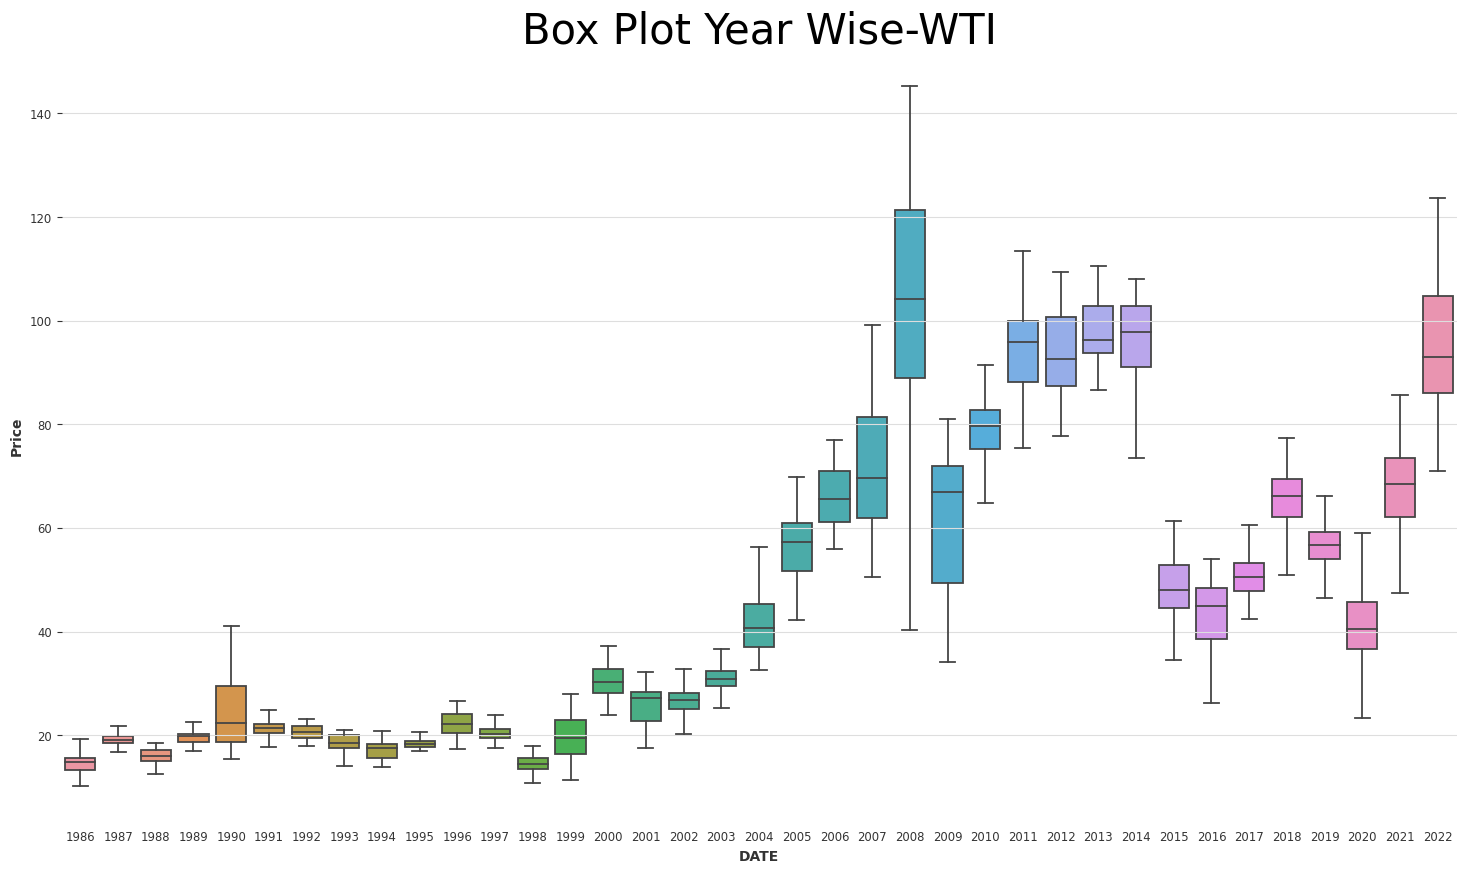

In [147]:
##Box Plot Year Wise WTI
plt.figure(figsize=(18,10))
ax = sns.boxplot(x=df_result['DATE'], y=df_result['Price'])
ax.set_title('Box Plot Year Wise-WTI',fontsize=30)

-> During the years 2007, 2008, and 2009 wide variations in the values of WTI have been observed.

-> In the year 2008, which is the period of the financial crisis and huge volatality, the WTI oil price varies between 30-140$.

-> Years 2002, 2008, 2014 & 2018 show outliers.

In [148]:
oil_filled = df_result.copy()

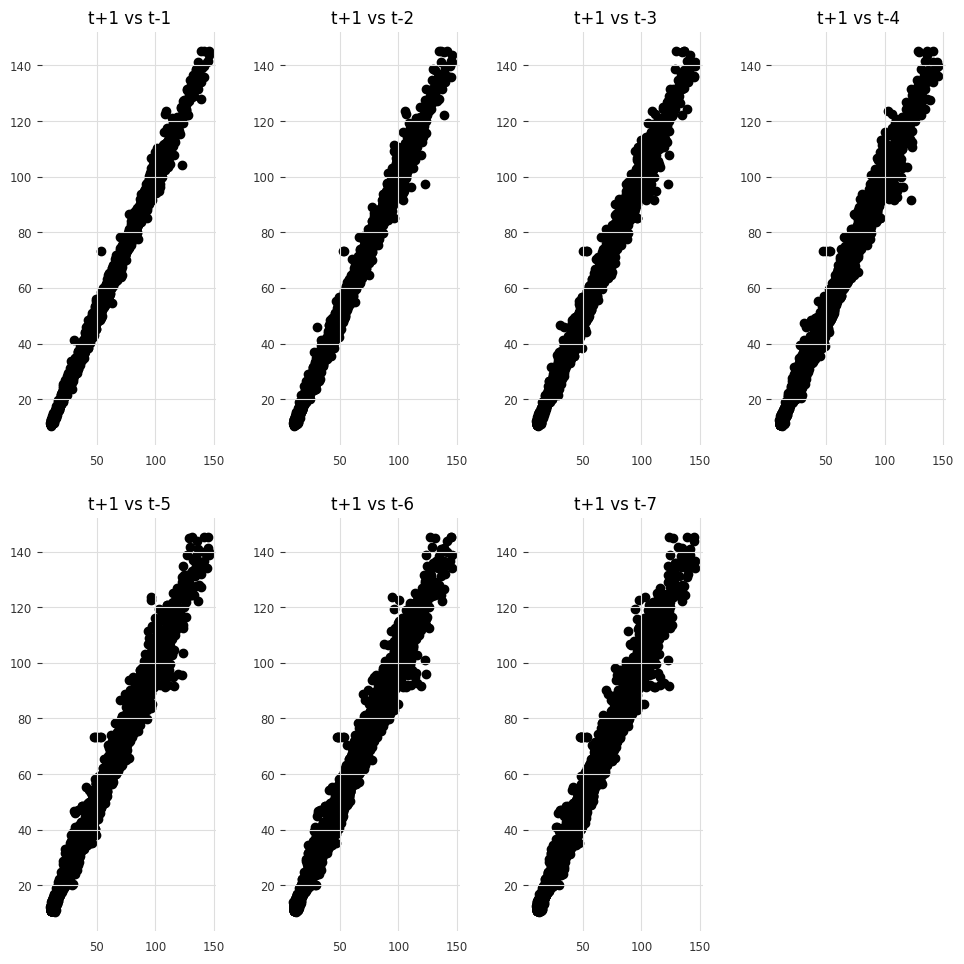

In [149]:
plt.figure(figsize=(10,10))
pd.plotting.lag_plot(oil_filled['Price'])
wti_series = oil_filled['Price']
n_lags = 7
cols = [wti_series]

for i in range(1,(n_lags + 1)):
	cols.append(wti_series.shift(i))
df = pd.concat(cols, axis=1)
cols = ['t+1']
for i in range(1,(n_lags + 1)):
	cols.append('t-' + str(i))
df.columns = cols
plt.figure(1)
for i in range(1,(n_lags + 1)):
	ax = plt.subplot(240 + i)
	ax.set_title('t+1 vs t-' + str(i))
	plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)
plt.tight_layout(pad=2)
plt.show()

##Stationary

###Adfuller

In [150]:
from statsmodels.tsa.stattools import adfuller
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(oil_filled['Price'].values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.211959553338395
p-value: 0.2019334985345026
Critial Values:
   1%, -3.4310304376403438
Critial Values:
   5%, -2.86184071162785
Critial Values:
   10%, -2.566930063685475


This suggests that we can accept the null hypothesis with a significance level i.e., the series isn't stationary

###Mean and Varience

In [151]:
oil_filled_1 = oil_filled[0:4500]
oil_filled_2 = oil_filled[4500:9748]

In [152]:
oil_filled_1['Price'].mean(),oil_filled_2['Price'].mean()

(20.716844444444444, 68.31530182453416)

In [153]:
oil_filled_1['Price'].var(),oil_filled_2['Price'].var()

(26.89229394667951, 559.9502958599131)

Mean and Varince having huge difference so time series has not stationary

<Axes: >

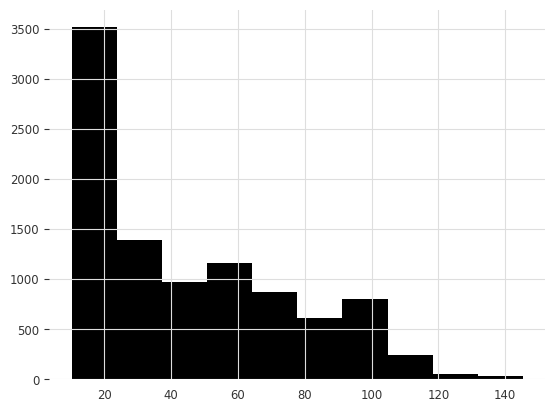

In [154]:
oil_filled['Price'].hist()

###Make a Time Series Stationary
There are 3 major reasons behind non-stationaruty of a TS:

differencing

seasonaly

transformation

<Axes: xlabel='DATE'>

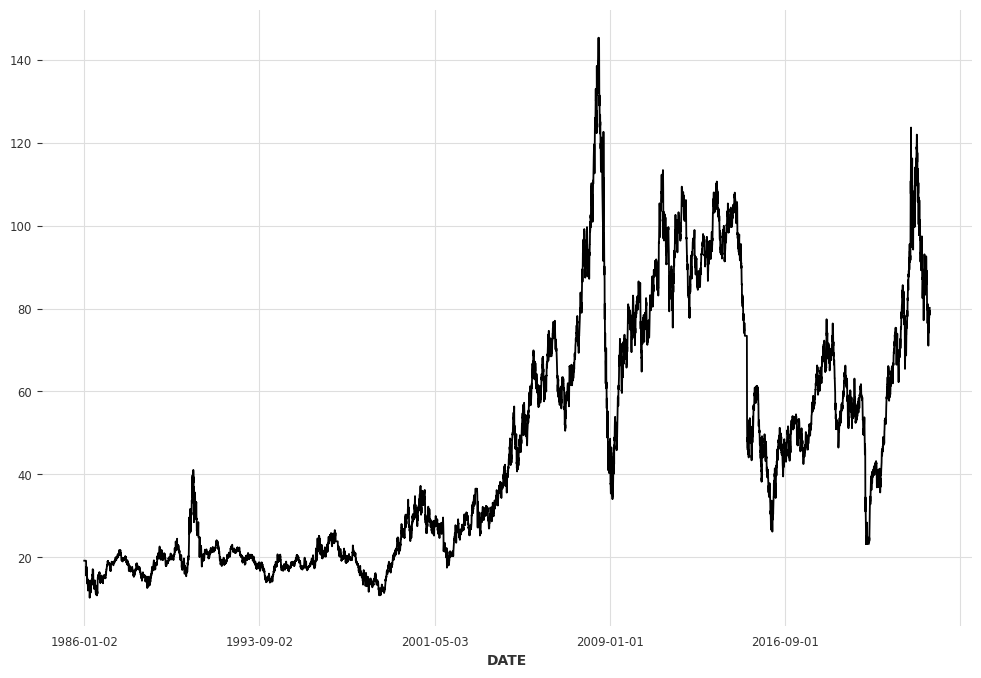

In [155]:
oil_filled['Price'].plot(figsize=(12,8))

##Method 1- Differencing

In [156]:
oil_filled11 = oil_filled.copy()

In [157]:
oil_filled11['Price_diff'] = oil_filled11['Price'] - oil_filled11['Price'].shift(1)
oil_filled11 = oil_filled11.drop(oil_filled11.index[0])

In [158]:
oil_filled11

,Price,DATE,Price_diff
DATE,,,
1986-01-03,19.17875,1986,0.00
1986-01-06,19.17875,1986,0.00
1986-01-07,19.17875,1986,0.00
1986-01-08,19.17875,1986,0.00
1986-01-09,19.17875,1986,0.00
...,...,...,...
2022-12-26,79.57000,2022,0.00
2022-12-27,79.45000,2022,-0.12
2022-12-28,78.89000,2022,-0.56


In [159]:
# ADF Test - nul hypothesis - non-stationary - if p-value < 5% reject null hypothesis
adfuller_result = adfuller(oil_filled11['Price_diff'].values, autolag='AIC')

print(f'ADF Statistic: {adfuller_result[0]}')

print(f'p-value: {adfuller_result[1]}')

for key, value in adfuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.334656835321947
p-value: 1.0851837603056314e-26
Critial Values:
   1%, -3.4310304376403438
Critial Values:
   5%, -2.86184071162785
Critial Values:
   10%, -2.566930063685475


###Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

In [160]:
from statsmodels.tsa.stattools import kpss

In [161]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [162]:
kpss_test(oil_filled11['Price'])

Results of KPSS Test:
Test Statistic           10.138681
p-value                   0.010000
#Lags Used               58.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


The p-value obtained is greater than the significance level of 0.05, and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is, in fact, non-stationary

<Axes: xlabel='DATE'>

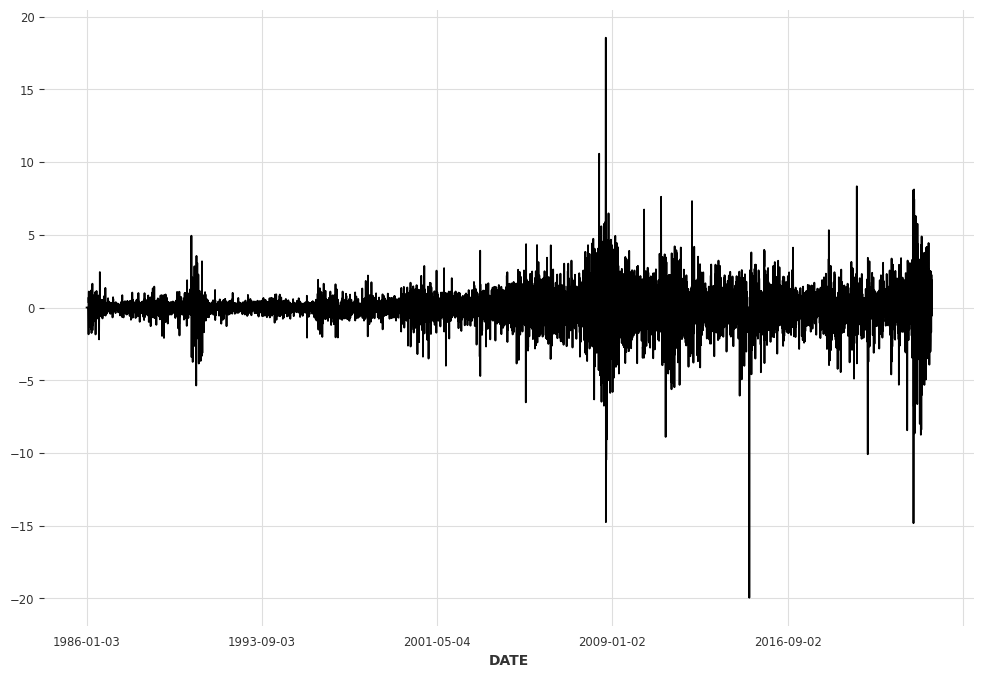

In [163]:
oil_filled11['Price_diff'].plot(figsize=(12,8))

Now that we have a better understanding of the type of series we are working with, we could go ahead and try different ARIMA models out, however the autoarima method from the darTS package automates the whole process so we'll just use that. Because of the two above tests, we'll set  d=1
 , but we'll let the AutoARIMA functionaliy determine the best values of  p
  and  q
  for us.

##Train-test Split
We separate the data into a training and a test set.

In [164]:
oil_filled.head()

,Price,DATE
DATE,,
1986-01-02,19.17875,1986
1986-01-03,19.17875,1986
1986-01-06,19.17875,1986
1986-01-07,19.17875,1986
1986-01-08,19.17875,1986


In [165]:
oil_filled.drop(['DATE'],axis=1,inplace=True)

In [166]:
oil_filled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9652 entries, 1986-01-02 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9652 non-null   float64
dtypes: float64(1)
memory usage: 408.9+ KB


In [167]:
sep_date = '2018-01-01'
X_train = oil_filled[:sep_date]
X_test = oil_filled[sep_date:]

In [58]:
X_test

,Price
DATE,
2018-01-01,60.46
2018-01-02,60.37
2018-01-03,61.61
2018-01-04,61.98
2018-01-05,61.49
...,...
2022-12-26,79.57
2022-12-27,79.45
2022-12-28,78.89


###DARTS

Now we'll look at the performance of different darts models

**Darts arima**


In [59]:
pip install 'u8darts[pmdarima]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.0/694.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.6/273.6 kB 16.2 MB/s eta 0:00:00
 

In [60]:
import pmdarima as pm

In [61]:
oil_filled = oil_filled.reset_index()
oil_filled['DATE']= pd.to_datetime(oil_filled['DATE'])

In [62]:
oil_filled = oil_filled.set_index("DATE")

In [63]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
import time

In [64]:
#Creating timeseries object for demand
from darts import TimeSeries
series_demand = TimeSeries.from_dataframe(oil_filled, value_cols='Price')
series_demand

<TimeSeries (DataArray) (DATE: 9652, component: 1, sample: 1)>
array([[[19.17875]],

       [[19.17875]],

       [[19.17875]],

       ...,

       [[78.89   ]],

       [[78.43   ]],

       [[80.16   ]]])
Coordinates:
  * DATE       (DATE) datetime64[ns] 1986-01-02 1986-01-03 ... 2022-12-30
  * component  (component) object 'Price'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

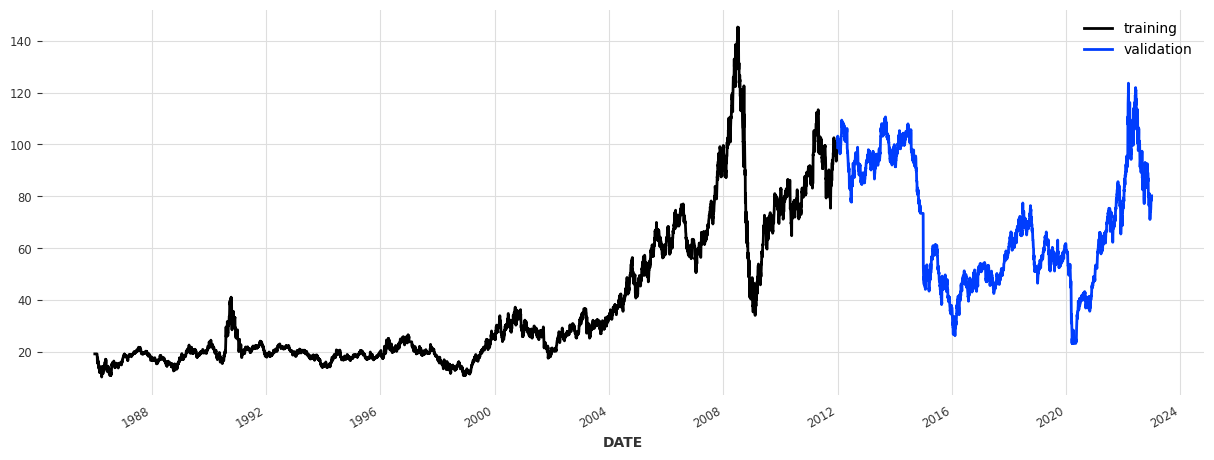

In [65]:
train, val = series_demand.split_before(pd.Timestamp("20120101"))
plt.figure(figsize=(15,5))
train.plot(label="training")
val.plot(label="validation")

##Darts arima

In [66]:
best_model = pm.auto_arima(X_train, start_p=1, start_q=1, max_p=10, max_q=10,
                             start_P=0, seasonal=False, trace=True, d=1,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25658.846, Time=3.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25674.065, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25660.997, Time=0.78 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25659.971, Time=1.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25672.226, Time=0.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25653.525, Time=13.95 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25653.324, Time=4.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25650.228, Time=4.49 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=25648.966, Time=3.78 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=25633.415, Time=5.08 sec
 ARIMA(6,1,0)(0,0,0)[0] intercept   : AIC=25634.329, Time=9.33 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=25634.156, Time=19.90 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=25638.598, Time=9.98 sec
 ARIMA(6,1,1)(0,0,0)[0] intercept   : AIC=25636.345, Time=3.87 sec
 ARIMA(5,1,0)(0,0

In [67]:
best_model.fit(X_train)

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [68]:
from darts import TimeSeries
from darts.models.forecasting.arima import ARIMA as dartsarima

In [69]:
def forecasts(model, value_series, start_date, end_date):
    y_train = TimeSeries.from_series(value_series[:start_date])
    y_test = TimeSeries.from_series(value_series[start_date:end_date])
    model.fit(y_train)
    forecasts = model.historical_forecasts(y_test, start=.1, forecast_horizon=1)
    return forecasts.pd_series()

In [70]:
def forecasts_rmse(actual_prices, forecasted_prices):
    '''
    Input: two pandas Dataframes
    Output: two floats (the rmse and smape)
    Returns the root mean squared error between the actual price and the forecasted price.
    '''
    start_date = forecasted_prices.index[0]
    return (mean_squared_error(actual_prices[start_date:], forecasted_prices), 
            smape(actual_prices[start_date:], forecasted_prices))

In [71]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = oil_filled.index[-1]
model_ARIMA = dartsarima(p=5, d=1, q=0)
darts_arima_forecasts = forecasts(model_ARIMA, oil_filled, start_date, end_date)

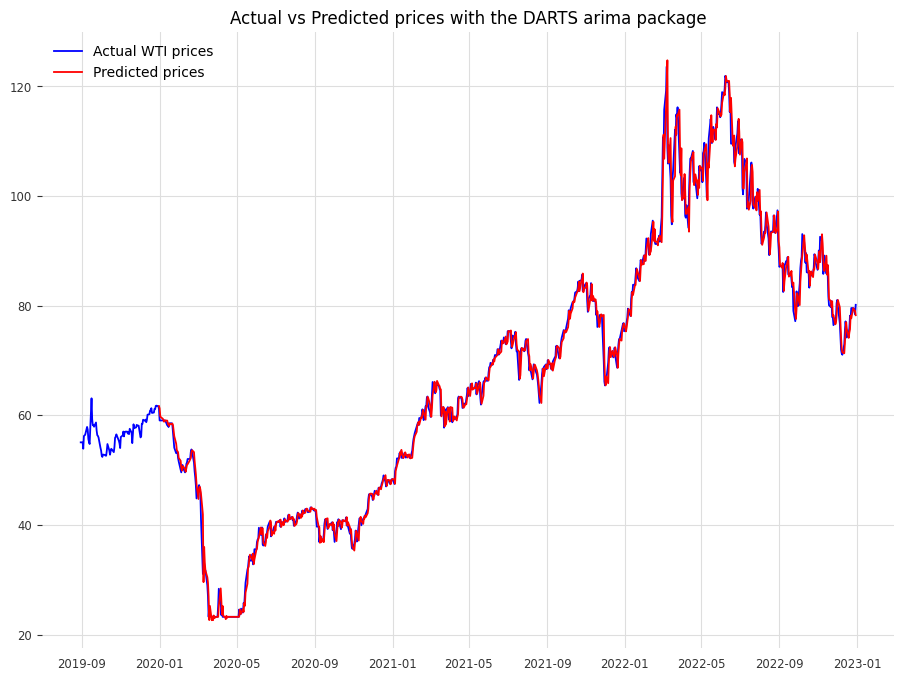

In [72]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled[start_date:'2025-01-01'], label='Actual WTI prices', color='blue')
plt.plot(darts_arima_forecasts, color='red', label='Predicted prices' )
plt.title('Actual vs Predicted prices with the DARTS arima package')
plt.legend()

<Figure size 1500x800 with 0 Axes>

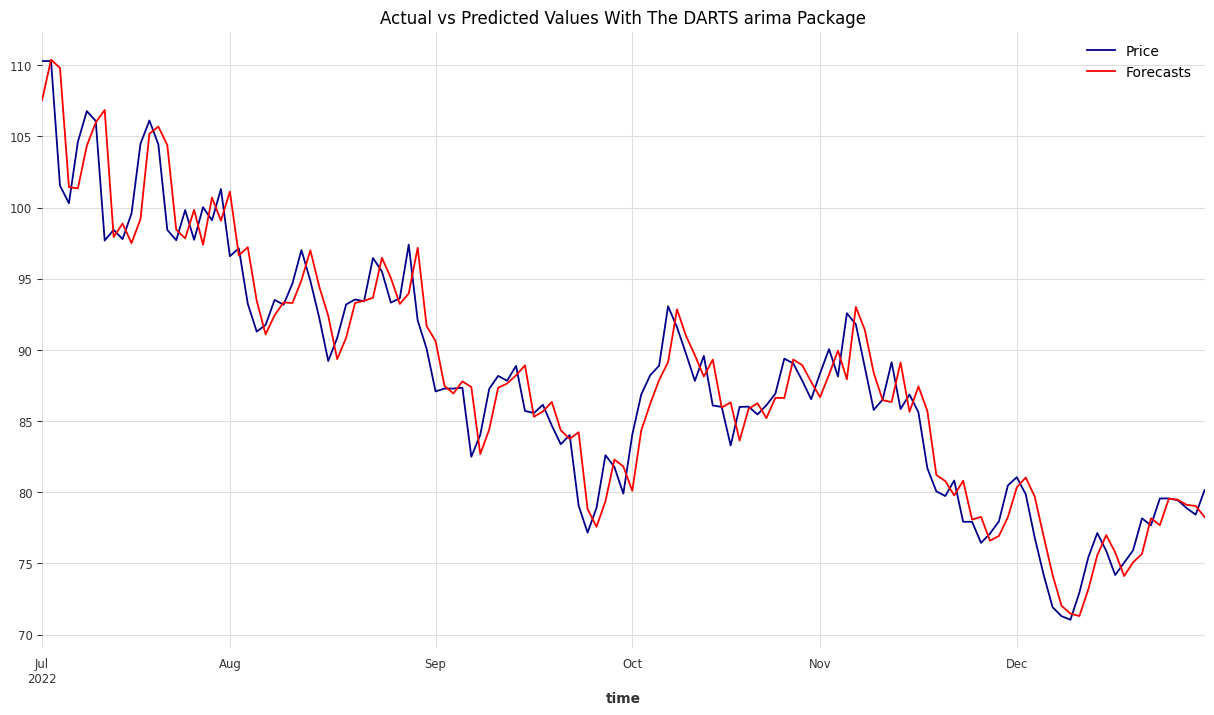

In [73]:
start = '2022-07-01'
plt.figure(figsize=(15, 8))
oil_filled[start:].plot(color='darkblue', label='Actual WTI values',figsize=(15,8))
darts_arima_forecasts[start:].plot(color='red', label='Forecasts',figsize=(15,8))
plt.title('Actual vs Predicted Values With The DARTS arima Package')
plt.legend();

In [74]:
forecasts_rmse(oil_filled['Price'], darts_arima_forecasts)

(4.272991512806873, 2.033305255781375)

##Other DARTS models

**Facebook's Prophet**

In [86]:
from darts.models.forecasting.prophet_model import Prophet

In [87]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = oil_filled.index[-1]
model_Prophet = Prophet()
prophet_forecasts = forecasts(model_Prophet, oil_filled, start_date, end_date)

Streaming output truncated to the last 5000 lines.
INFO:cmdstanpy:Chain [1] start processing
03:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpppkqu50c/9x74jekq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpppkqu50c/hs6hsfc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27455', 'data', 'file=/tmp/tmpppkqu50c/9x74jekq.json', 'init=/tmp/tmpppkqu50c/hs6hsfc4.json', 'output', 'file=/tmp/tmpppkqu50c/prophet_model1r8_ij67/prophet_model-20230612032358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:23:58 - cmdstanpy - INFO - Chain [1] start 

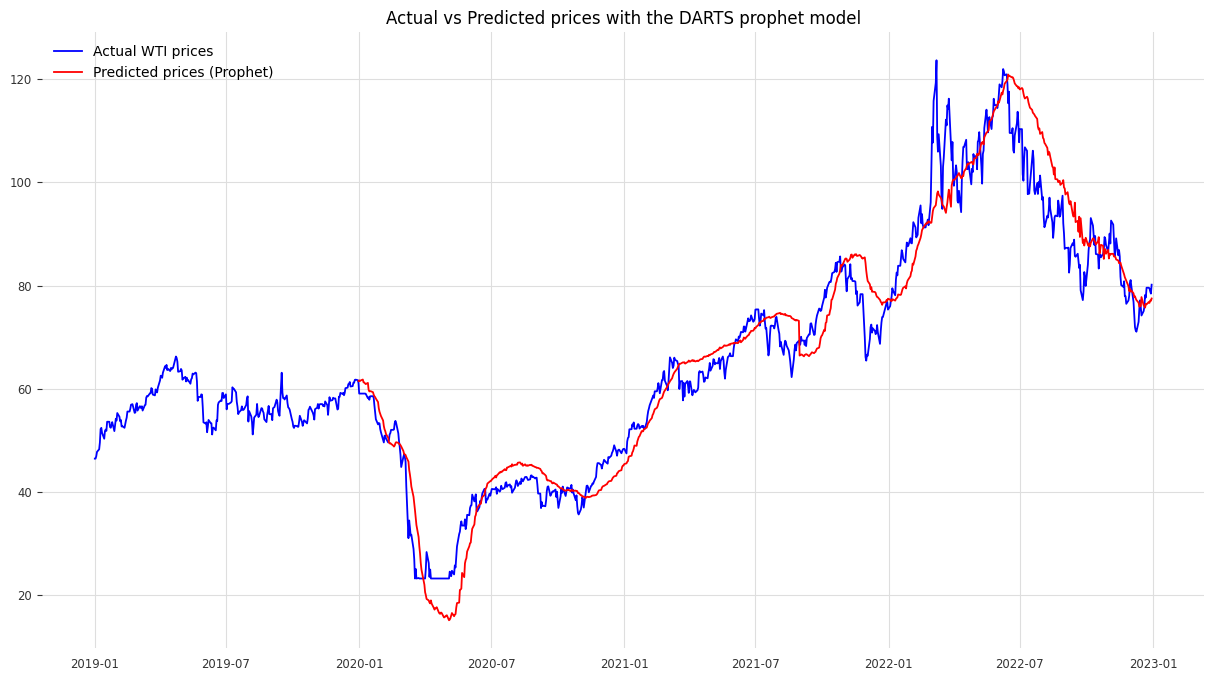

In [88]:
plt.figure(figsize=(15, 8))
plt.plot(oil_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(prophet_forecasts, color='red', label='Predicted prices (Prophet)' )
plt.title('Actual vs Predicted prices with the DARTS prophet model')
plt.legend()

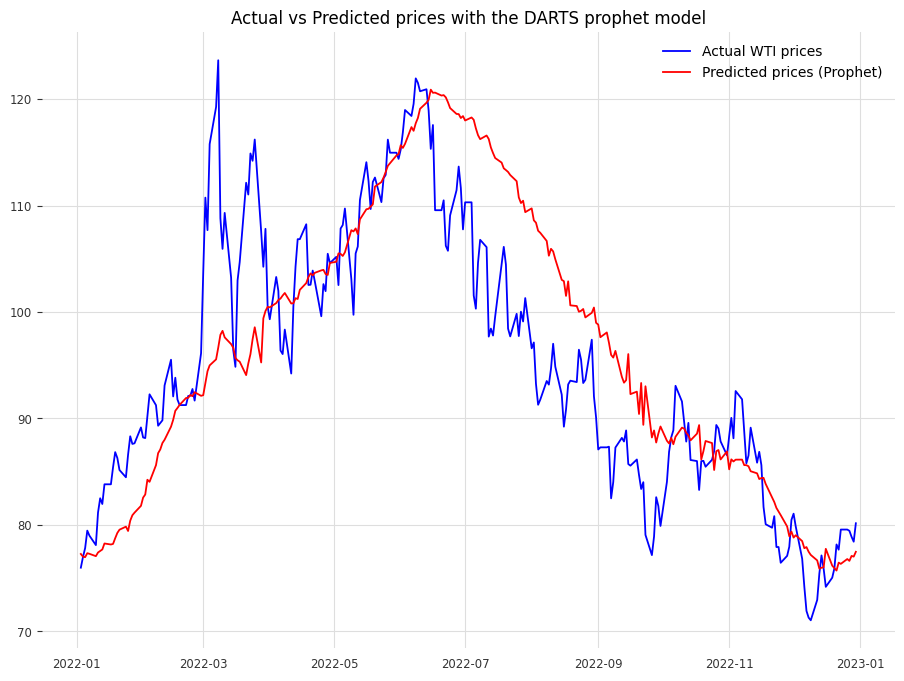

In [89]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2022-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(prophet_forecasts['2022-01-01':end_date], color='red', label='Predicted prices (Prophet)' )
plt.title('Actual vs Predicted prices with the DARTS prophet model')
plt.legend()

In [90]:
forecasts_rmse(oil_filled[start_date:oil_filled.index[-1]], prophet_forecasts)


(35.61048427333286, 7.956107427960705)

Prophet's results¶
Despite the long compuation time needed to run the prophet model, one sees very clearly from the graph, and as is corroborated by the computation of RMSE and SMAPE (7.9% !)

###Darts Exponential smoothing model

In [91]:
from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing

In [92]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = oil_filled.index[-1]
model_ExponentialSmoothing = ExponentialSmoothing()
expsmooth_forecasts = forecasts(model_ExponentialSmoothing, oil_filled, start_date, end_date)

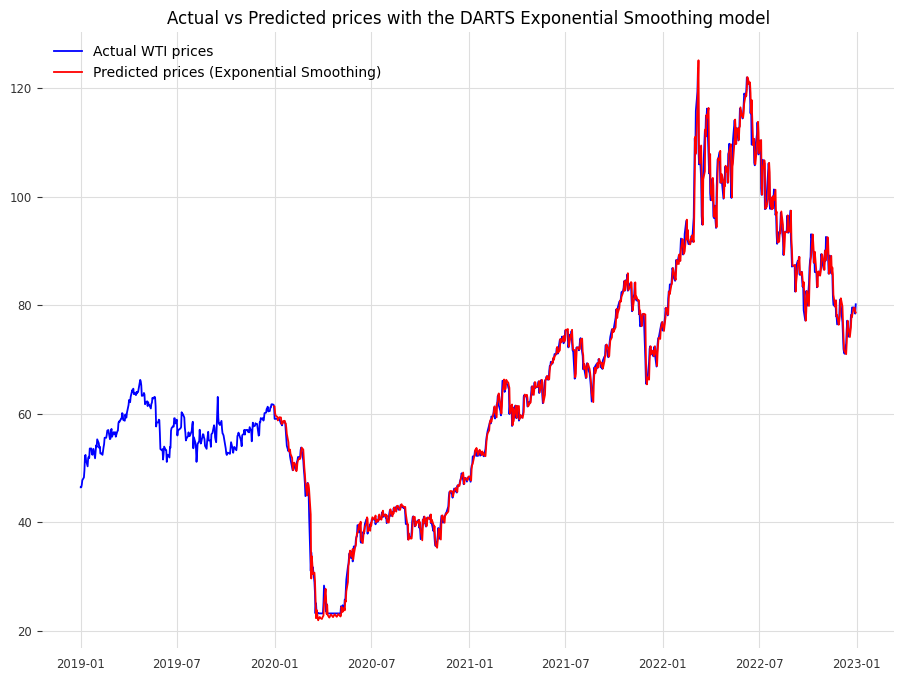

In [93]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(expsmooth_forecasts, color='red', label='Predicted prices (Exponential Smoothing)' )
plt.title('Actual vs Predicted prices with the DARTS Exponential Smoothing model')
plt.legend()

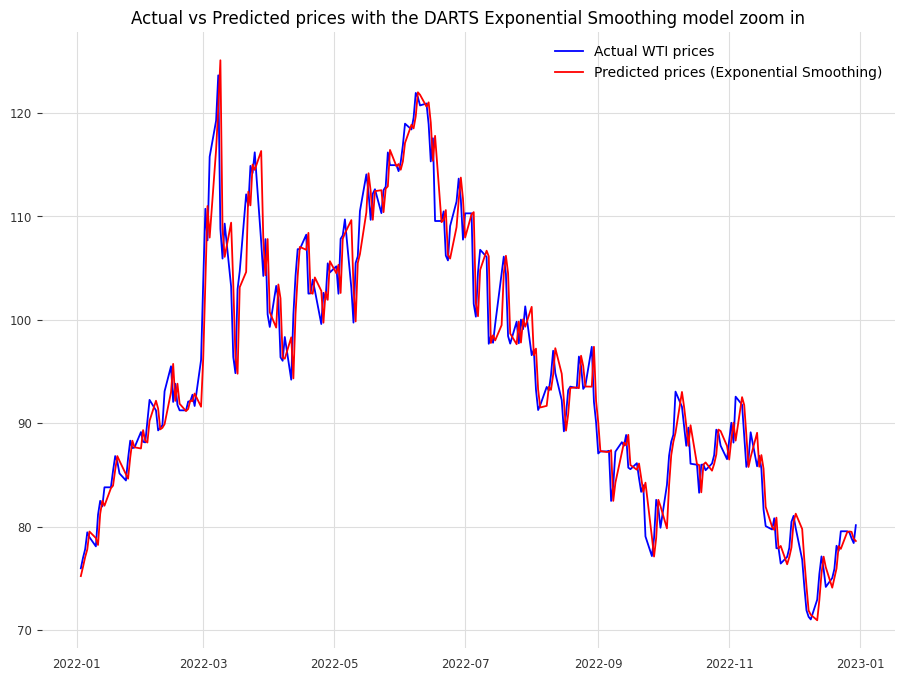

In [94]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2022-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(expsmooth_forecasts['2022-01-01':end_date], color='red', label='Predicted prices (Exponential Smoothing)' )
plt.title('Actual vs Predicted prices with the DARTS Exponential Smoothing model zoom in')
plt.legend()

In [95]:
forecasts_rmse(oil_filled[start_date:end_date], expsmooth_forecasts)

(4.276675831589844, 2.0904447686783314)

Exponential Smoothing Results

The error is not too bad now, comparable to the one obtained by the ARIMA method from darts. Let's see if random forests can get a better error now.

### DARTS random forest

In [96]:
from darts.models.forecasting.random_forest import RandomForest

In [97]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = oil_filled.index[-1]
model_RandomForest =  RandomForest(lags=5)
randomforest_forecasts = forecasts(model_RandomForest, oil_filled, start_date, end_date)

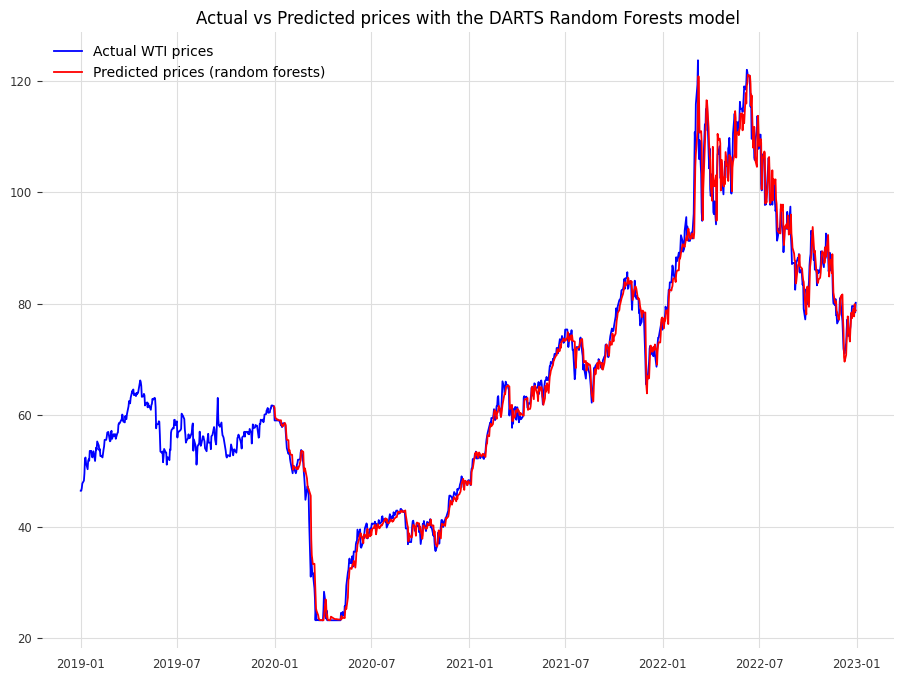

In [98]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(randomforest_forecasts, color='red', label='Predicted prices (random forests)' )
plt.title('Actual vs Predicted prices with the DARTS Random Forests model')
plt.legend()

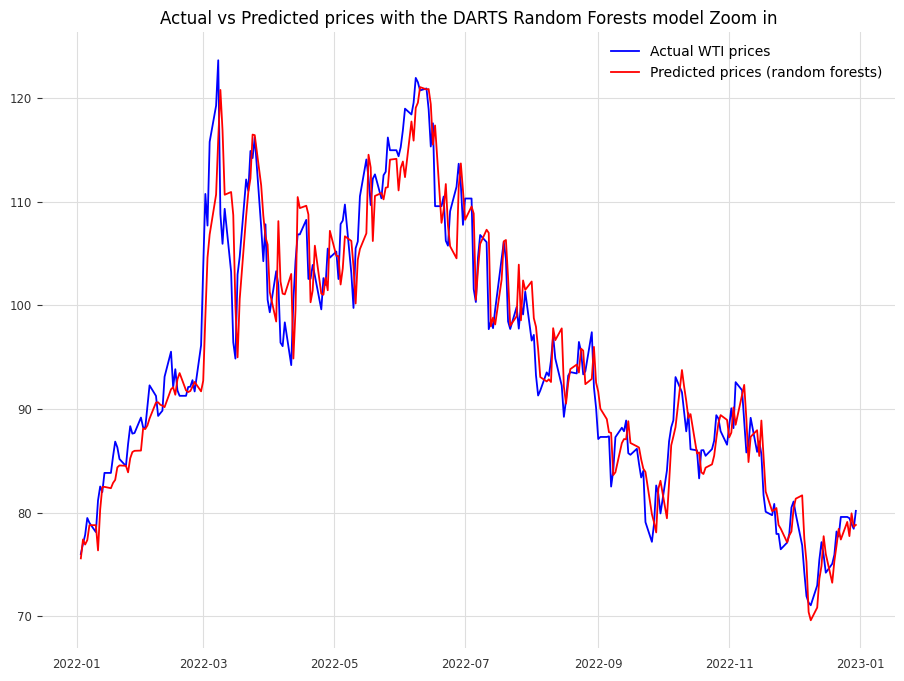

In [99]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2022-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(randomforest_forecasts['2022-01-01':end_date], color='red', label='Predicted prices (random forests)' )
plt.title('Actual vs Predicted prices with the DARTS Random Forests model Zoom in')
plt.legend()

In [100]:
forecasts_rmse(oil_filled[start_date:end_date], randomforest_forecasts)

(5.923452778603067, 2.4717721152223957)

## Darts Linear Regression Model

In [101]:
from darts.models.forecasting.linear_regression_model import LinearRegressionModel

In [ ]:
start_date = '2019-08-30' #Chosen so that the intervals of the DARTS and PMDARIMA pacakges coincide
end_date = oil_filled.index[-1]
model_LinearRegressionModel =  LinearRegressionModel(lags=5)
linear_forecasts = forecasts(model_LinearRegressionModel, oil_filled, start_date, end_date)

In [ ]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2019-01-01':end_date], label='Actual WTI prices', color='blue')
plt.plot(linear_forecasts, color='red', label='Predicted prices (linear regression)' )
plt.title('Actual vs Predicted prices with the DARTS lienar regression model')
plt.legend()

In [ ]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2020-01-01':'2020-07-01'], label='Actual WTI prices', color='blue')
plt.plot(linear_forecasts[start_date:'2020-07-01'], color='red', label='Predicted prices (Linear Regression)' )
plt.title('Actual vs Predicted prices with the DARTS Linear Regression model (zoomed in)')
plt.legend()

In [ ]:
forecasts_rmse(oil_filled[start_date:end_date], linear_forecasts)

In [106]:
import statsmodels.api as sm

model_AA = sm.tsa.arima.ARIMA(oil_filled.Price, order=(2, 2, 10))  
results_ARIMA = model_AA.fit()  

In [107]:
arima_pred = results_ARIMA.predict(oil_filled['Price'].index[6000], oil_filled['Price'].index[-1], typ="levels")

In [108]:
arima_pred

2009-01-01    44.348380
2009-01-02    44.633888
2009-01-05    46.174249
2009-01-06    48.406887
2009-01-07    48.373269
                ...    
2022-12-26    79.721433
2022-12-27    79.336047
2022-12-28    79.282148
2022-12-29    79.157366
2022-12-30    78.269963
Freq: B, Name: predicted_mean, Length: 3652, dtype: float64

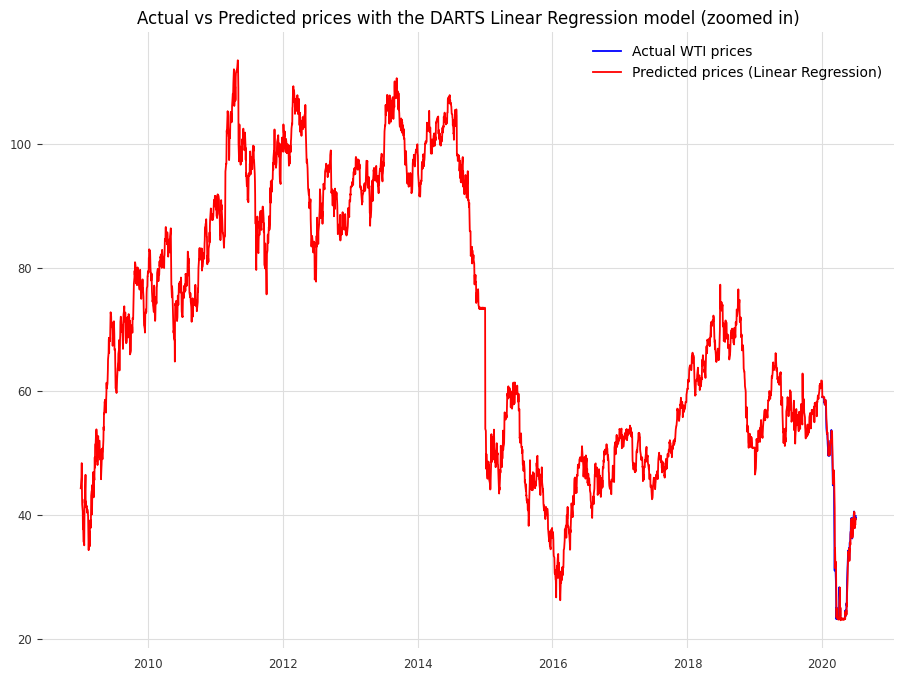

In [109]:
plt.figure(figsize=(11, 8))
plt.plot(oil_filled['2020-01-01':'2020-07-01'], label='Actual WTI prices', color='blue')
plt.plot(arima_pred['2009-01-01':'2020-07-01'], color='red', label='Predicted prices (Linear Regression)' )
plt.title('Actual vs Predicted prices with the DARTS Linear Regression model (zoomed in)')
plt.legend()

In [ ]:
mean_squared_error(actual_prices[start_date:], forecasted_prices

##LSTM

In [168]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')


In [169]:
df = oil_filled.copy()

In [170]:
df = df.sort_values('DATE')
df = df.groupby('DATE')['Price'].sum().reset_index()
df.set_index('DATE', inplace=True)


In [171]:
#Read dataframe info
def DfInfo(df_initial):
    # gives some infos on columns types and numer of null values
    tab_info = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0: 'null values (nb)'}))
    tab_info = tab_info.append(pd.DataFrame(df_initial.isnull().sum() / df_initial.shape[0] * 100).T.
                               rename(index={0: 'null values (%)'}))
    return tab_info

In [172]:
# normalize the data_set 
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [173]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [174]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [175]:
# reshape into X=t and Y=t+1
look_back =90
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [176]:
# create and fit the LSTM network regressor = Sequential() 
regressor = Sequential()

regressor.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 60))
regressor.add(Dropout(0.1))

regressor.add(Dense(units = 1))


regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =regressor.fit(X_train, Y_train, epochs = 20, batch_size = 15,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
445/445 [==============================] - 101s 176ms/step - loss: 0.0024 - val_loss: 0.0255 - lr: 0.0010
Epoch 2/20
445/445 [==============================] - 78s 176ms/step - loss: 0.0063 - val_loss: 0.0350 - lr: 0.0010
Epoch 3/20
445/445 [==============================] - 80s 180ms/step - loss: 0.0089 - val_loss: 0.0583 - lr: 0.0010
Epoch 4/20
445/445 [==============================] - 78s 174ms/step - loss: 0.0091 - val_loss: 0.0536 - lr: 0.0010
Epoch 5/20
445/445 [==============================] - 77s 174ms/step - loss: 0.0052 - val_loss: 0.0294 - lr: 0.0010
Epoch 6/20
445/445 [==============================] - 80s 180ms/step - loss: 0.0021 - val_loss: 0.0052 - lr: 0.0010
Epoch 7/20
445/445 [==============================] - 78s 175ms/step - loss: 0.0012 - val_loss: 0.0046 - lr: 0.0010
Epoch 8/20
445/445 [==============================] - 80s 181ms/step - loss: 0.0011 - val_loss: 0.0050 - lr: 0.0010
Epoch 9/20
445/445 [==============================] - 78s 175ms/step - 

In [177]:
train_predict = regressor.predict(X_train)
test_predict = regressor.predict(X_test)

88/88 [==============================] - 4s 42ms/step


In [178]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

In [179]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Test Mean Absolute Error: 1.7664247641877904
Test Root Mean Squared Error: 2.3529608814031495


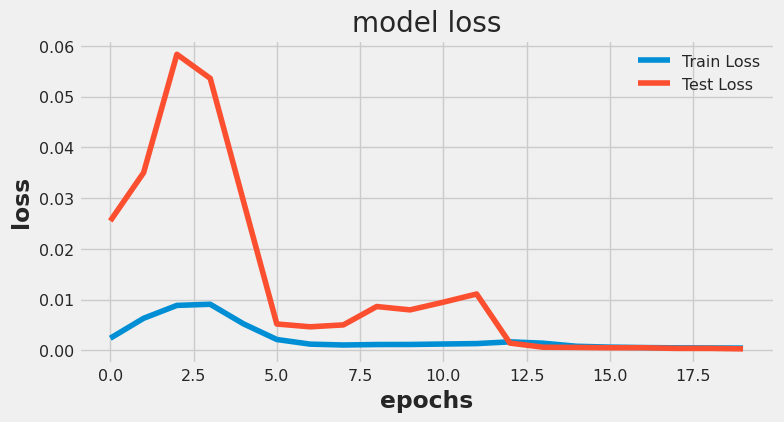

In [185]:
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

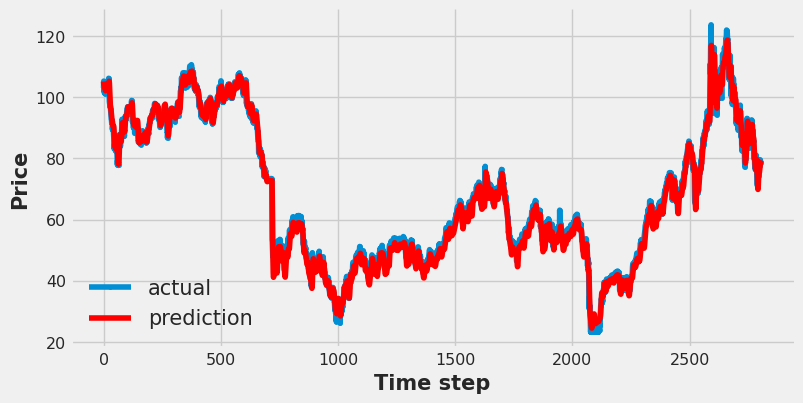

In [184]:
#Compare Actual vs. Prediction
aa=[x for x in range(2805)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:2805], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:2805], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [182]:
# save model
regressor.save('keras_model.h5')